In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology

import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings
import h5py

In [48]:
snap = 47
if snap > 294:
    pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d'%snap)
else:
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_%03d'%snap)

# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


----------PIG file info------------
Redshift = 6.00
Lbox = 250000 ckpc/h
NfofGroups = 179648902
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [49]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%snap
pig2 = BigFile(outdir)

### subfind summary check

In [50]:
gLength = pig['FOFGroups/LengthByType']
gOffset = pig['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

In [51]:
firstsub = FirstSub[:1000]
np.where(firstsub > 2579)[0][0] - 1

2

In [28]:
mass4 = sMass[:]

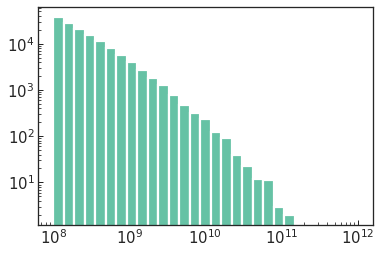

In [29]:
bins = np.logspace(8,12,30)
plt.hist(mass4[:,4]*1e10/hh,bins=bins)
plt.xscale('log')
plt.yscale('log')

#### mass/position check

Main subgroup

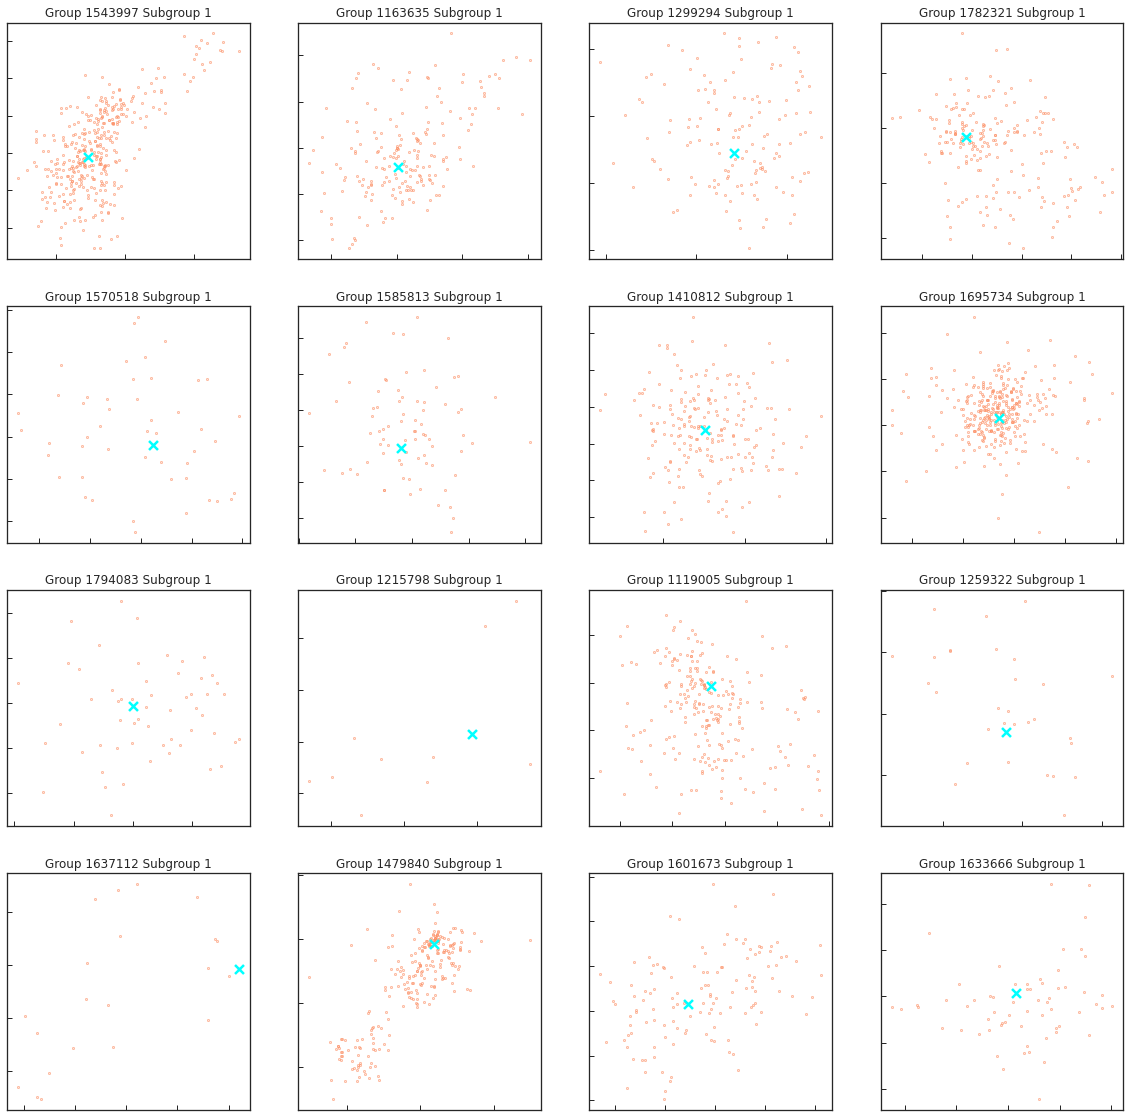

In [63]:
p = 0
gidx = 3
isub = 1

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.random.choice(range(1000000,2000000), 16, replace=False)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    

    sstart = sOffset[sidx]
    send   = sOffset[sidx] + sLength[sidx]

    m1 = sMass[sidx][p]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    assert np.allclose(m1,m2, atol=1e-3),"%.1e,%.1e"%(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
# plt.savefig('test_sub0.png',bbox_inches='tight')
plt.show()

### chunk data

In [56]:
grpfile = '/hildafs/datasets/Asterix/subfind/subfind_214/chunk1.2/output/snap_214.hdf5'
tabfile = '/hildafs/datasets/Asterix/subfind/subfind_214/chunk1.2/output/fof_subhalo_tab_214.hdf5'
pos4 = h5py.File(grpfile,'r')['PartType4/Coordinates'][:]
offset = h5py.File(tabfile,'r')['Subhalo/SubhaloOffsetType'][:]
length = h5py.File(tabfile,'r')['Subhalo/SubhaloLenType'][:]
centers = h5py.File(tabfile,'r')['Subhalo/SubhaloPos'][:]

In [58]:
centers[i,0]

33796.316

In [47]:
gidx = 8
gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]
print(gstart[4],gend[4])
pos4g = pig2['4/Position'][gstart[4]:gend[4]]

33092767 36946028


75


<Figure size 720x720 with 0 Axes>

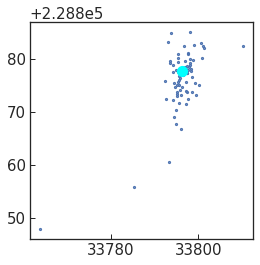

51


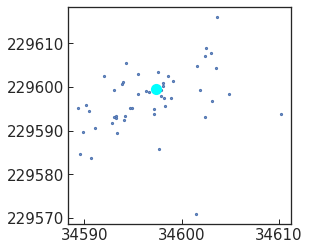

73


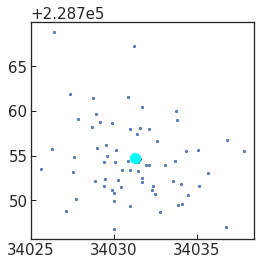

72


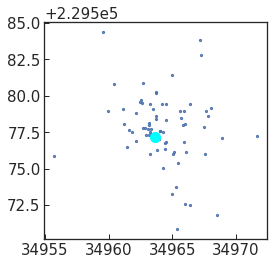

89


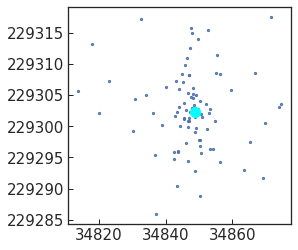

47


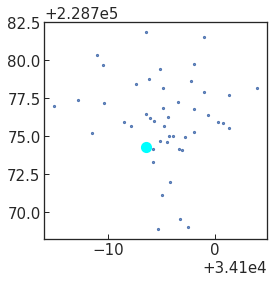

6


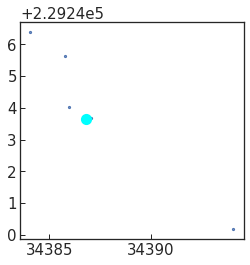

83


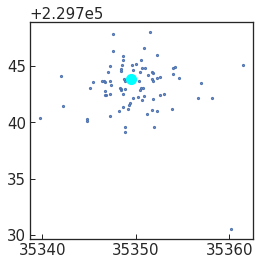

51


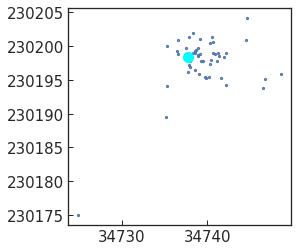

51


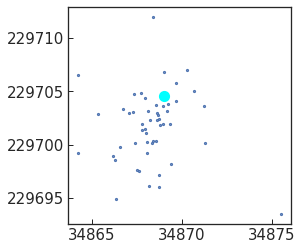

In [60]:
fig = plt.figure(figsize=(10,10))
# plt.scatter(pos4g[:,0],pos4g[:,1],s=1,color='grey')
for i in range(200,210):
    fig = plt.figure(figsize=(4,4))
    beg,end = offset[i], offset[i] + length[i]
    plt.scatter(pos4[beg[4]:end[4]][:,0],pos4[beg[4]:end[4]][:,1],s=1,color='b')
    plt.scatter(centers[i,0],centers[i,1],color='cyan',s=80)
    print(length[i][4])

    plt.show()

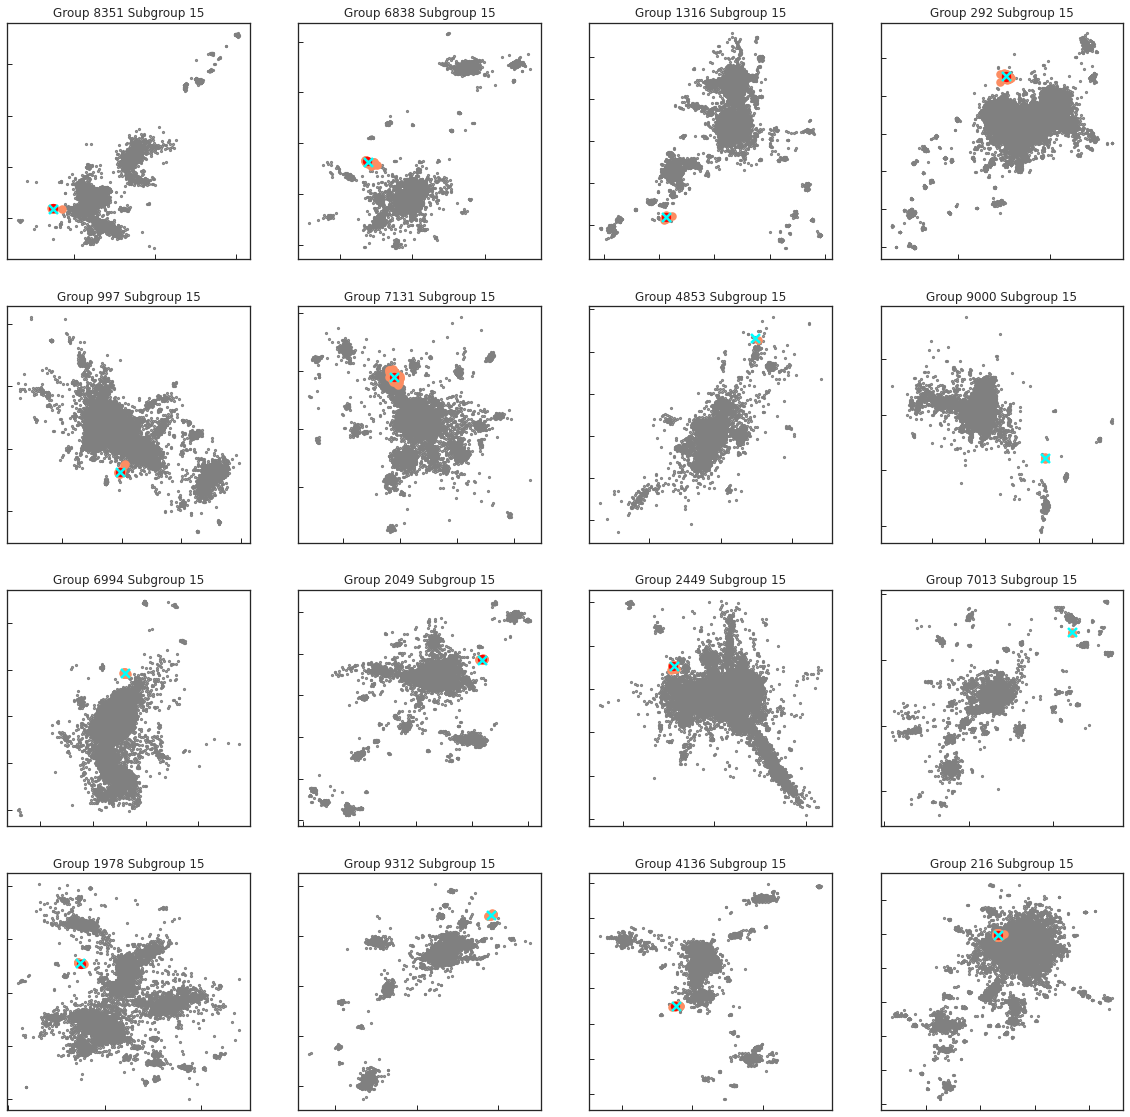

In [117]:
p = 4
gidx = 3
isub = 15

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.random.choice(range(10000), 16, replace=False)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    
    m1 = sMass[sidx][4]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    assert np.allclose(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=40,color=cmap(1))
    ax[i].scatter(bpos[:,0],bpos[:,1],s=50,color='red')
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
plt.savefig('test_sub3.png',bbox_inches='tight')
plt.show()

In [40]:
BHGroup = pig2['5/GroupID'][:]

In [44]:
gidx = 300
start,end = gOffset[gidx][5], gOffset[gidx][5]+gLength[gidx][5]
pig2['5/SubIDinGroup'][start:end]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   3,   4,
         4,   5,   6,   7,   7,   7,   7,   8,   8,   9,   9,   9,   9,
         9,   9,   9,  10,  11,  12,  13,  14,  15,  15,  16,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  24,  25,  26,  27,  27,  28,
        29,  30,  30,  31,  32,  33,  34,  35,  35,  36,  37,  3

In [42]:
BHGroup[-10000]-1

22300973

### BH offset test

In [18]:
# BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
# bidxlist, = np.where(BHMass > 5e5)
bidxlist = np.random.choice(1000000, 50000)
# bmass = BHMass[bidxlist]
# del BHMass
print(len(bidxlist))

50000


In [19]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:]
suboff5 = suboff[:,5]
del suboff

In [20]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [21]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


Error: b"Failed to read in block `/hildafs/datasets/Asterix/PIG2/PIG_107_subfind/5/Position' at (157:0) (No such file or directory) @(src/bigfile.c:861)"

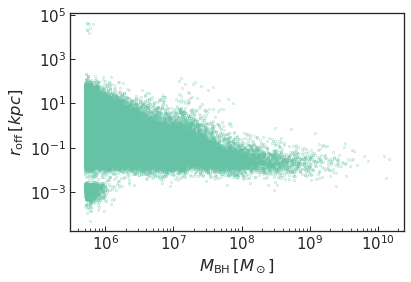

In [19]:
plt.scatter(bmass,roff/6,s=0.1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.ylabel(r'$r_{\rm off}\,[kpc]$')
plt.yscale('log')

112808

63
466215
21493
[[218214820 155266310         0         0 156207911     21475]
 [218774943 156321418         0         0 158231430     21536]]
[[ 560123 1055108       0       0 2023519      61]
 [  50031   51910       0       0   20712       2]]
[ 560123 1055108       0       0 2023519      61]
[218214820 155266310         0         0 156207911     21475] [218774943 156321418         0         0 158231430     21536]


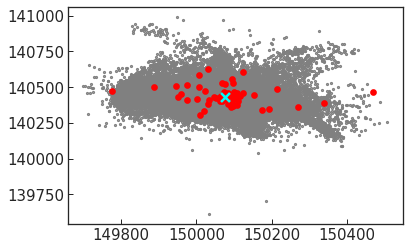

In [14]:
mask = roff > 100
blist = bidxlist[mask]
slist = sidxlist[mask]
print(len(blist))


sidx = slist[16]
print(sidx)
print(blist[16])

soff = pig2['SubGroups/SubhaloOffsetType'][sidx]
slen = pig2['SubGroups/SubhaloLenType'][sidx]


print(pig2['SubGroups/SubhaloOffsetType'][sidx:sidx+2])
print(pig2['SubGroups/SubhaloLenType'][sidx:sidx+2])
sbeg,send = soff, soff + slen
print(slen)
print(sbeg,send)
pos5 = pig2['5/Position'][sbeg[5]:send[5]]
pos4 = pig2['4/Position'][sbeg[4]:send[4]]
# pos1 = pig2['1/Position'][sbeg[1]:send[1]]


center = pig2['SubGroups/SubhaloPos'][sidx]

plt.scatter(pos4[:,0],pos4[:,1],s=1,color='grey')
# plt.scatter(pos1[:,0],pos1[:,1],s=1,color='grey')
plt.scatter(pos5[:,0],pos5[:,1],s=20,color='red')
plt.scatter(center[0],center[1],marker='x',color='cyan',s=80)
plt.show()

### write summary tests

In [149]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_214_subfind'
dest_r = BigFile(outdir)

In [109]:
def get_Nsubs(istart,iend):
    Nsubs = []
    for c in chunks[istart:iend]:
        subdir  = subroot + '/chunk%d.%d/output/'%(c,maxgroup_list[c])
        tabfile = subdir + tab
        if "Subhalo" in h5py.File(tabfile,'r').keys():
            try:
                NsubsChunk  = h5py.File(tabfile,'r')['Header'].attrs['Nsubgroups_Total']
            except KeyError:
                NsubsChunk  = h5py.File(tabfile,'r')['Header'].attrs['Nsubhalos_Total']
        else:
            NsubsChunk  = 0
        Nsubs.append(NsubsChunk)
    return Nsubs

In [110]:
def process_chunk(c, ChunkFirstSub):
    """
    write summary statistics for each chunk
    write Nsubs, first sub for each group
    """
    # groups in this chunk
    print('Processing chunk:',c,flush=True)
    subdir  = subroot + '/chunk%d.%d/output/'%(c,maxgroup_list[c])
    tabfile = subdir + tab


    if c == 0:
        gstart, gend = 0, maxgroup_list[c]
    else:
        gstart, gend = maxgroup_list[c-1], maxgroup_list[c]
        
    if "Subhalo" in h5py.File(tabfile,'r').keys():
        Subhalo = h5py.File(tabfile,'r')['Subhalo']
        SubhaloTotMass = Subhalo['SubhaloMass'][:]
        SubLengthChunk = Subhalo['SubhaloLenType'][:]
    else:
        # no subhalo in the entire chunk
        # nothing to do
        print('No subgroups at all in chunk%d'%c,flush=True)
        return  ChunkFirstSub
        
    SidxFOF2Chunk  = np.argsort(SubhaloTotMass)[::-1]
    GroupSidxList  = [get_GroupSidx(gidx) for gidx in range(gstart,gend)]
    SubLenList     = [SubLengthChunk[s] for s in GroupSidxList]
    GroupSidxChunk = np.concatenate(GroupSidxList)
    NsubsChunk     = np.array([len(s) for s in GroupSidxList])
    FirstSubs      = np.zeros_like(NsubsChunk) + ChunkFirstSub
    FirstSubs[1:]  +=  np.cumsum(NsubsChunk[:-1])
    GroupOff       = Offset[gstart:gend]
    SubOffChunk    = [get_SubgroupOff(GroupOff[i],SubLenList[i]) for i in range(len(GroupOff))]
    SubOffChunk    = np.concatenate(SubOffChunk,axis=0)
    
    write_groups_chunk(gstart,FirstSubs,NsubsChunk)
    print('step4',flush=True)
    write_subgroups_chunk(ChunkFirstSub,SidxFOF2Chunk,GroupSidxChunk,SubOffChunk,Subhalo)
    print('step5',flush=True)

    return  FirstSubs[-1]

In [111]:

def get_subfind_chunk(subroot):
    subdir = subroot + '/*'
    
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    return chunk_list, maxgroup_list 

In [153]:
FUZZ    = 100000000
def get_GroupSidx(gidx):
    start,end = Offset[gidx], Offset[gidx] + Length[gidx]
    # assume that each subgroup must have a DM particle
    subID = np.concatenate([dest_r['%d/SubgroupID'%p][start[p]:end[p]] for p in [0,1,4,5]])

    subID_set   = set(subID)
    if len(subID_set) == 0 or min(list(subID_set)) == FUZZ:
        # no substructure in this group
        return np.array([],dtype=np.int32)
    
    if max(list(subID_set)) == FUZZ:
        # there is inner fuzz
        subID_set.remove(FUZZ)
    subID_arr = np.sort(np.array(list(subID_set)))
    return subID_arr


def get_SubgroupOff(GroupOff,SubLen):
    if len(SubLen) == 0:
        return np.zeros((0,6),dtype = np.int32)
    SubOff = np.concatenate([GroupOff[None,:], GroupOff[None,:] + np.cumsum(SubLen[:-1],axis=0)],axis=0)
    return SubOff

In [112]:
subroot = '/hildafs/datasets/Asterix/subfind/subfind_214'
tab = "fof_subhalo_tab_214.hdf5"
grp = "snap_214.hdf5"
chunk_list, maxgroup_list = get_subfind_chunk(subroot)
chunks = chunk_list


Length  = pig['FOFGroups/LengthByType']
Offset  = pig['FOFGroups/OffsetByType']
    
    
    

In [114]:
chunks[717]
maxgroup_list[717]

36079821

In [155]:
cstart,cend = 0,20

istart0,iend0 = 0,10
istart1,iend1 = 10,20

NsubsList0 = get_Nsubs(istart0,iend0)
NsubsList1 = get_Nsubs(istart1,iend1)
print(sum(NsubsList0))
TaskOff = sum([sum(NsubsList0),sum(NsubsList1)][:1])
print(TaskOff)

print(NsubsList1)

110536.0
110536.0
[10199, 8912, 9080, 8634, 8438, 8436, 7925, 7390, 8353, 7864]


In [156]:
istart0,iend0 = 0,10
NsubsList0 = get_Nsubs(istart0,iend0)

In [157]:
c = 10
ChunkFirstSub = int(TaskOff)
print(ChunkFirstSub)

print('Processing chunk:',c,flush=True)
subdir  = subroot + '/chunk%d.%d/output/'%(c,maxgroup_list[c])
tabfile = subdir + tab


if c == 0:
    gstart, gend = 0, maxgroup_list[c]
else:
    gstart, gend = maxgroup_list[c-1], maxgroup_list[c]

if "Subhalo" in h5py.File(tabfile,'r').keys():
    Subhalo = h5py.File(tabfile,'r')['Subhalo']
    SubhaloTotMass = Subhalo['SubhaloMass'][:]
    SubLengthChunk = Subhalo['SubhaloLenType'][:]
    print(len(SubLengthChunk))
else:
    # no subhalo in the entire chunk
    # nothing to do
    print('No subgroups at all in chunk%d'%c,flush=True)



110536
Processing chunk: 10
10199


In [159]:
SidxFOF2Chunk  = np.argsort(SubhaloTotMass)[::-1]
print(SidxFOF2Chunk)
GroupSidxList  = [get_GroupSidx(gidx) for gidx in range(gstart,gend)]
print(GroupSidxList)


SubLenList     = [SubLengthChunk[s] for s in GroupSidxList]
print(SubLenList)

GroupSidxChunk = np.concatenate(GroupSidxList)
print(GroupSidxChunk)



NsubsChunk     = np.array([len(s) for s in GroupSidxList])
print(NsubsChunk)




FirstSubs      = np.zeros_like(NsubsChunk) + ChunkFirstSub
FirstSubs[1:]  +=  np.cumsum(NsubsChunk[:-1])
print('First subs:',FirstSubs)

GroupOff       = Offset[gstart:gend]

print('----groupoff--------')
print(GroupOff)

SubOffChunk    = [get_SubgroupOff(GroupOff[i],SubLenList[i]) for i in range(len(GroupOff))]
SubOffChunk    = np.concatenate(SubOffChunk,axis=0).astype(int)
print('-------------------------')
print(SubOffChunk)



len(SubOffChunk)

print(sum(NsubsChunk)+ChunkFirstSub)

[   0    2    1 ... 9909 9876 8839]
[array([    0,     1,     2, ..., 10196, 10197, 10198], dtype=int32)]
[array([[1222726, 1469473,       0,       0, 1265305,      55],
       [ 130757,  207341,       0,       0,  342326,      10],
       [ 199549,  207079,       0,       0,  130031,      10],
       ...,
       [     12,      21,       0,       0,       0,       0],
       [     16,      16,       0,       0,       0,       0],
       [     28,       4,       0,       0,       0,       0]],
      dtype=int32)]
[    0     1     2 ... 10196 10197 10198]
[10199]
First subs: [110536]
----groupoff--------
[[130207704  35952871         0         0  39993021      4953]]
-------------------------
[[130207704  35952871         0         0  39993021      4953]
 [131430430  37422344         0         0  41258326      5008]
 [131561187  37629685         0         0  41600652      5018]
 ...
 [132714601  39081529         0         0  42541580      5383]
 [132714613  39081550         0         0  

In [113]:
SidxFOF2Chunk 

array([   0,    2,    1, ..., 9909, 9876, 8839])

In [114]:
feature = 'SubhaloLenType'
data    = Subhalo[feature][:][SidxFOF2Chunk[GroupSidxChunk]]

In [115]:
data

array([[1222726, 1469473,       0,       0, 1265305,      55],
       [ 199549,  207079,       0,       0,  130031,      10],
       [ 130757,  207341,       0,       0,  342326,      10],
       ...,
       [     20,       0,       0,       0,       0,       0],
       [      6,       0,       0,       0,      14,       0],
       [      5,       0,       0,       0,      19,       0]],
      dtype=int32)

In [73]:

def subhalo_offset(tabfile):
    SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
    GroupLenType = h5py.File(tabfile,'r')['Group']['GroupLenType'][:]
    GroupNsubs = h5py.File(tabfile,'r')['Group']['GroupNsubs'][:]
    GroupFirst = h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]
    
    
    SubhaloOffsetType = np.zeros_like(SubhaloLenType,dtype=int)
    GroupOff = np.zeros(6,dtype=int)
    SubOff = np.zeros(6,dtype=int)
    for ig,lgroup in enumerate(GroupLenType):
        SubOff[:] = GroupOff[:]
        nsub = GroupNsubs[ig]
        firstsub = GroupFirst[ig]
        if firstsub == -1:
            GroupOff += lgroup
            continue
        print(ig,GroupOff)
        for isub in range(firstsub,firstsub + nsub):
            # print(nsub,firstsub,isub)
            SubhaloOffsetType[isub] = SubOff
            SubOff += SubhaloLenType[isub]
        GroupOff += lgroup
        print(np.sum(GroupLenType[:ig],axis=0))
    return SubhaloOffsetType
    

In [74]:
# GroupOff = np.zeros(6,dtype=int)
# for ig,lgroup in enumerate(GroupLenType):
#     print(np.sum(GroupLenType[:ig],axis=0))
#     print(GroupOff)
#     GroupOff += lgroup
    
#     print('------------------')

In [75]:
tabfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk53.54/output/fof_subhalo_tab_348.hdf5'
off = subhalo_offset(tabfile)

0 [0 0 0 0 0 0]
[0 0 0 0 0 0]
14 [3073384 3936504       0       0 3867733     526]
[3073384 3936504       0       0 3867733     526]
22 [3073662 3936818       0       0 3867733     526]
[3073662 3936818       0       0 3867733     526]


In [76]:
off

array([[      0,       0,       0,       0,       0,       0],
       [2517377, 3197258,       0,       0, 2426539,     160],
       [2653502, 3373069,       0,       0, 2769467,     181],
       ...,
       [2883657, 3842438,       0,       0, 3866842,     526],
       [3073384, 3936504,       0,       0, 3867733,     526],
       [3073662, 3936818,       0,       0, 3867733,     526]])

In [77]:
SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
GroupLenType = h5py.File(tabfile,'r')['Group']['GroupLenType'][:]
GroupFirst = h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]

In [80]:
for i,f in enumerate(GroupFirst):

    if f < 0:
        continue
    print(i,f)
    print(off[f])

    print(np.sum(GroupLenType[:i],axis=0))
    print('-----------------------')

0 0
[0 0 0 0 0 0]
[0 0 0 0 0 0]
-----------------------
14 1434
[3073384 3936504       0       0 3867733     526]
[3073384 3936504       0       0 3867733     526]
-----------------------
22 1435
[3073662 3936818       0       0 3867733     526]
[3073662 3936818       0       0 3867733     526]
-----------------------


In [60]:
np.sum(GroupLenType[:14],axis=0)

array([3073384, 3936504,       0,       0, 3867733,     526])

## 348

In [61]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_348_subfind'
pig2 = BigFile(outdir)
pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348')

Length = pig['FOFGroups/LengthByType']
Offset = pig['FOFGroups/OffsetByType']
dest_r = pig2

gLength = pig2['FOFGroups/LengthByType']
gOffset = pig2['FOFGroups/OffsetByType']
FirstSub = pig2['FOFGroups/GroupFirstSub']

sLength = pig2['SubGroups/SubhaloLenType']
sOffset = pig2['SubGroups/SubhaloOffsetType']
sMass = pig2['SubGroups/SubhaloMassType']

NSubs = pig2['FOFGroups/GroupNsubs']

### Nsub per chunk inconsistency

In [62]:
subroot = '/hildafs/datasets/Asterix//subfind/subfind_348'
tab="fof_subhalo_tab_348.hdf5"
grp = "snap-groupordered_348.hdf5"

In [63]:
def get_subfind_chunk(subroot):
    subdir = subroot + '/*'
    
    chunk_list    = []
    maxgroup_list = []
    for ff in sorted(glob.glob(subdir)):
        cname    = ff.split('/')[-1]
        chunk    = int(cname.split('.')[0][5:])
        maxgroup = int(cname.split('.')[1])
        
        chunk_list.append(chunk)
        maxgroup_list.append(maxgroup)
        
    sort  = np.argsort(chunk_list)
    chunk_list    = np.array(chunk_list)[sort]
    maxgroup_list = np.array(maxgroup_list)[sort]
    return chunk_list, maxgroup_list 

In [64]:
chunk_list, maxgroup_list = get_subfind_chunk(subroot)
len(chunk_list)
chunks = chunk_list

In [7]:
def get_Nsubs(istart,iend):
    Nsubs = []
    for c in chunks[istart:iend]:
        subdir  = subroot + '/chunk%d.%d/output/'%(c,maxgroup_list[c])
        tabfile = subdir + tab
        if "Subhalo" in h5py.File(tabfile,'r').keys():
            try:
                NsubsChunk  = h5py.File(tabfile,'r')['Header'].attrs['Nsubgroups_Total']
            except KeyError:
                NsubsChunk  = h5py.File(tabfile,'r')['Header'].attrs['Nsubhalos_Total']
        else:
            NsubsChunk  = 0
        Nsubs.append(NsubsChunk)
    return Nsubs

In [9]:
sum(get_Nsubs(0,943))

57230393

In [46]:
for i in range(800,835):
    print(i)
    nsub_chunk = get_Nsubs(i,i+1)

    mingroup = maxgroup_list[i-1]
    maxgroup = maxgroup_list[i]

    
#     print('---', FirstSub[maxgroup] - FirstSub[mingroup])
    nsub2 = FirstSub[maxgroup-1] + NSubs[maxgroup-1] - FirstSub[mingroup]
    assert nsub_chunk[0]==nsub2, '%d %d'%(nsub_chunk[0],nsub2)

800
801
802
803
804
805
806
807
808
809
810
811


AssertionError: 99127 99128

In [11]:
def subhalo_offset(tabfile):
    SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
    GroupLenType = h5py.File(tabfile,'r')['Group']['GroupLenType'][:]
    GroupNsubs = h5py.File(tabfile,'r')['Group']['GroupNsubs'][:]
    GroupFirst = h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]
    
    SubhaloOffsetType = np.zeros_like(SubhaloLenType,dtype=int)
    GroupOff = np.zeros(6,dtype=int)
    SubOff = np.zeros(6,dtype=int)
    for ig,lgroup in enumerate(GroupLenType):
        SubOff[:] = GroupOff[:]
        nsub = GroupNsubs[ig]
        firstsub = GroupFirst[ig]
        if firstsub == -1:
            GroupOff += lgroup
            continue
        for isub in range(firstsub,firstsub + nsub):
            SubhaloOffsetType[isub] = SubOff
            SubOff += SubhaloLenType[isub]
        GroupOff += lgroup
    return SubhaloOffsetType

def assign_sid_chunk(tabfile,grpfile):
    # this may not exist for certain snapshots!

    SubhaloOffType = subhalo_offset(tabfile)
    SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
    SubhaloTotMass = h5py.File(tabfile,'r')['Subhalo']['SubhaloMass'][:]

    # sort chunk subhalos by mass
    sort_mass = np.argsort(SubhaloTotMass)[::-1]
        
    grp_Nsubs      = h5py.File(tabfile,'r')['Group']['GroupNsubs'][:]
    Npart          = h5py.File(grpfile,'r')['Header'].attrs['NumPart_ThisFile']
    
    Ngroups = len(grp_Nsubs)
    Nsubs   = len(SubhaloLenType)
    # --------------------------------------------------------------------
    # if we only care about subgroups then
    # we can assign unique subgroup ids in this chunk?
    sgpIDs = {}
    for p in [0,1,4,5]:
        # default to large integer so that the wandering 
        # particles are sorted to the end
        # better re-order all subgroups in think chunk by mass
        # to guarantee that old fof subgroups following the 
        # mass ordering
        sf_sgpID = FUZZ * np.ones(Npart[p],dtype='i4')
        scount = 0
        for i,s in enumerate(sort_mass):
            sN = SubhaloLenType[s]
            sO = SubhaloOffType[s]
            sf_sgpID[sO[p]:sO[p]+sN[p]]=i
        sgpIDs[p] = sf_sgpID
    return sgpIDs, SubhaloLenType



In [48]:
FUZZ = 100000000
sgpIDs, SubhaloLenType = assign_sid_chunk(tabfile,grpfile)

aa = set()
for p in [0,1,4,5]:
    aa = aa.union(set(sgpIDs[p]))
print(len(aa),len(SubhaloLenType))

524787 524786


In [12]:
def get_GroupSidx(gidx):
    start,end = gOffset[gidx], gOffset[gidx] + gLength[gidx]
    subID_set = set()
    for p in [0,1,4,5]:   # DO NOT assume that each subgroup has a DM particle!!
        subID_set = subID_set.union(set(dest_r['%d/SubgroupID'%p][start[p]:end[p]]))
    subID_arr = np.array(sorted(list(subID_set)))

    if len(subID_arr) == 0 or subID_arr[0] == FUZZ:
        # no substructure in this group
        return np.array([],dtype=np.int32)
    
    if subID_arr[-1] == FUZZ:
        # there is inner fuzz
        return subID_arr[:-1]
    return subID_arr

In [13]:
def get_ChunkSidx(gstart,gend):
    start,end = gOffset[gstart], gOffset[gend] + gLength[gend]
    subID_set = set()
    for p in [0,1,4,5]:   # DO NOT assume that each subgroup has a DM particle!!
        subID_set = subID_set.union(set(dest_r['%d/SubgroupID'%p][start[p]:end[p]]))
    subID_arr = np.array(sorted(list(subID_set)))

    if len(subID_arr) == 0 or subID_arr[0] == FUZZ:
        # no substructure in this group
        return np.array([],dtype=np.int32)
    
    if subID_arr[-1] == FUZZ:
        # there is inner fuzz
        return subID_arr[:-1]
    return subID_arr

In [14]:
c = 930
subdir  = subroot + '/chunk%d.%d/output/'%(c,maxgroup_list[c])
tabfile = subdir + tab
grpfile = subdir + grp

In [24]:
# gstart = maxgroup_list[i-1]
# gend   = maxgroup_list[i]
# GroupSidxList  = [get_GroupSidx(gidx) for gidx in range(gstart,gend)]
# sids = np.concatenate(GroupSidxList)
# NsubsChunk     = np.array([len(s) for s in GroupSidxList])
# NsubsTot       = sum(NsubsChunk)

In [18]:
FUZZ = 100000000
i = 900
gstart = maxgroup_list[i-1]
gend = maxgroup_list[i]
subIDs = get_ChunkSidx(gstart,gend)
print(max(subIDs),get_Nsubs(i,i+1))

286294 [286295]


In [20]:
for i in range(810,920):
    gstart = maxgroup_list[i-1]
    gend = maxgroup_list[i]
    subIDs = get_ChunkSidx(gstart,gend)
    print(max(subIDs),get_Nsubs(i,i+1)[0])

98326 98327
99126 99127
100146 100147
101201 101202


KeyboardInterrupt: 

In [17]:
max(subIDs)

286294

In [16]:
idset = set(subIDs)
for i in range(286295):
    if i not in idset:
        print(i)

### check subhalo catalog consistency

In [188]:
def get_SubgroupOff(GroupOff,SubLen):
    if len(SubLen) == 0:
        return np.zeros((0,6),dtype = np.int64)
    SubOff = np.zeros_like(SubLen,dtype=np.int64)
    SubOff[1:] = np.cumsum(SubLen[:-1],axis=0)
    return (SubOff + GroupOff).astype(np.int64)


def write_subgroup_offset(block,gstart,gend):
    if gstart < 1000:
        for gidx in range(gstart,gend):
            FirstSubs = dest_r['FOFGroups/GroupFirstSub'][gidx]
            Nsubs     =  dest_r['FOFGroups/GroupNsubs'][gidx]
            GroupOff  = dest_r['FOFGroups/OffsetByType'][gidx]
            SubLen    = dest_r['SubGroups/SubhaloLenType'][FirstSubs:FirstSubs+Nsubs]
            SubOff    = get_SubgroupOff(GroupOff,SubLen)
            # block.write(FirstSubs,SubOff)
            # print('group %d done!'%gidx)
            
    else:
        FirstSubs = dest_r['FOFGroups/GroupFirstSub'][gstart:gend]
        mask = FirstSubs > 0
        FirstSubs = FirstSubs[mask]
        Nsubs     =  dest_r['FOFGroups/GroupNsubs'][gstart:gend][mask]
        GroupOff  = dest_r['FOFGroups/OffsetByType'][gstart:gend][mask]
    
    
        sstart,send = FirstSubs[0], FirstSubs[-1] + Nsubs[-1]
        try:
            SubLen    = dest_r['SubGroups/SubhaloLenType'][sstart:send]
        except ValueError:
            print(gstart,gend,sstart,send,flush=True)
            assert 0==1
        FirstSubs = FirstSubs - FirstSubs[0]

        starts, ends = FirstSubs, FirstSubs + Nsubs
        SubOff = [get_SubgroupOff(GroupOff[i],SubLen[starts[i]: ends[i]]) for i in range(len(Nsubs))]

        SubOff = np.concatenate(SubOff, axis=0)
        # block.write(sstart,SubOff)
        # print('group %d done!'%(gend-1))
    return SubLen,SubOff

In [186]:
sLength.dtype

dtype(('<i4', (6,)))

In [212]:
FirstSub[30465028]

57228779

In [210]:
NSubs[30465028]

1

In [219]:
sOffset[57220778]

array([39923037214, 46263189021,           0,           0, 15554861594,
          11600254])

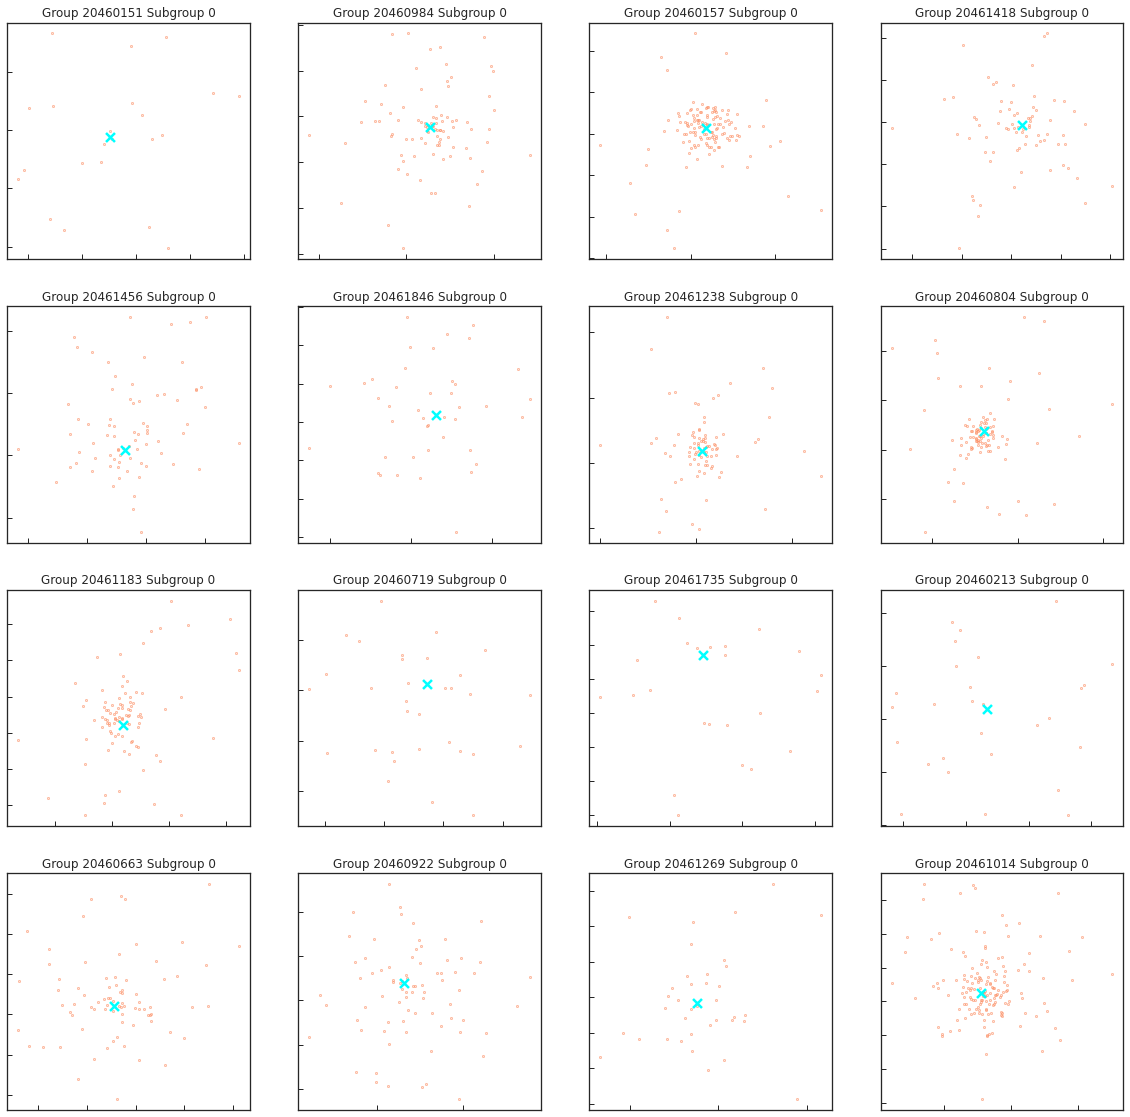

In [223]:
p = 0
isub = 0

fig,ax = plt.subplots(4,4,figsize=(20,20))
ax = ax.flatten()

test_groups = np.random.choice(range(20460029,20462029), 16, replace=False)

for i,gidx in enumerate(test_groups):
    firstsub = FirstSub[gidx]
    gstart,gend = gOffset[gidx], gOffset[gidx] + gLength[gidx]

    sidx = firstsub + isub
    
    sstart = (gstart + np.sum(sLength[firstsub:firstsub+isub],axis=0)).astype(int)
    send = (sstart + sLength[sidx]).astype(int)
    

    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))

    
    
#     SubLen,SubOff = write_subgroup_offset(block=0,gstart=gidx,gend=gidx+1)
    
#     sstart,send = SubOff[isub],SubOff[isub]+SubLen[isub]
#     print(sstart,send)

    m1 = sMass[sidx][p]
    m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)

    pos = pig2['%d/Position'%p][gstart[p]:gend[p]]
    spos = pig2['%d/Position'%p][sstart[p]:send[p]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 


    
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax[i].scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax[i].scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax[i].set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax[i].set(xticklabels=[],yticklabels=[])
# plt.savefig('test_sub0.png',bbox_inches='tight')
plt.show()

In [205]:
sLength.size

57230393

In [ ]:
# block = dest_r.create('SubGroups/test',dtype='i4',dsize =sLength.size,Nfiles=356)

### offset test

In [32]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 1e6)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

819576


In [71]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:54000000]
suboff5 = suboff[:,5]
del suboff

In [72]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:54000000][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [73]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


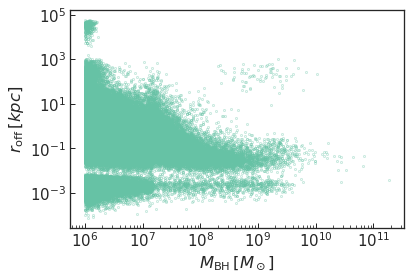

In [74]:
plt.scatter(bmass,roff/3,s=0.1)
plt.xscale('log')
plt.xlabel(r'$M_{\rm BH}\,[M_\odot]$')
plt.ylabel(r'$r_{\rm off}\,[kpc]$')
plt.yscale('log')

In [85]:
mask = roff>100
mask &= roff<500
sidx_trouble = sidxlist[mask]
bidx_trouble = bidxlist[mask]
len(set(sidx_trouble))

1727

In [87]:
FirstSub[1]

8487

In [76]:
len(sidx_trouble)

426

In [ ]:
p = 4
for i,sidx in enumerate(sidx_trouble[:20]):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)

    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
    target = pig2['5/Position'][bidx_trouble[i]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax.scatter(spos[:,0],spos[:,1],s=0.3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    ax.scatter(target[0],target[1],s=50,color='green')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    ax.set(xticklabels=[],yticklabels=[])
    plt.show()

[400]
[[ 32735.61872    226013.03226519 121485.04770004]]
400


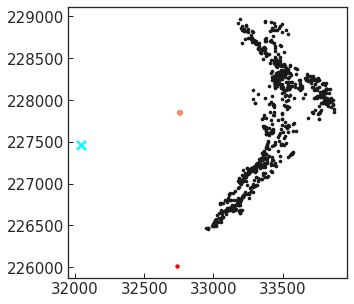

[401]
[[ 34483.40544218 229549.61722654 123369.62297851]]
401


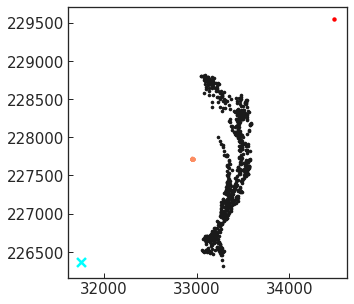

[402]
[[ 32869.04361947 227583.88563383 122299.33747011]]
402


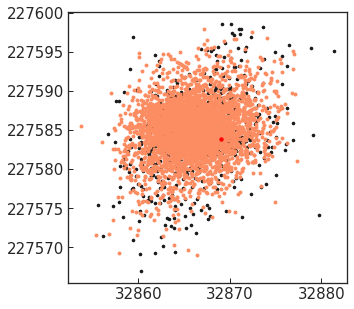

[403]
[[ 32259.34966271 226074.97318943 122693.4911157 ]]
403


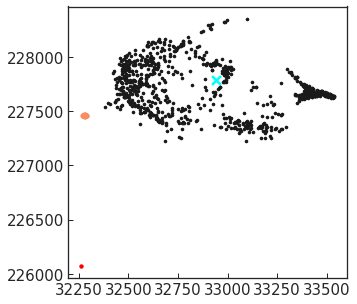

[404]
[[ 33268.94331863 227959.55890409 121973.32265307]]
404


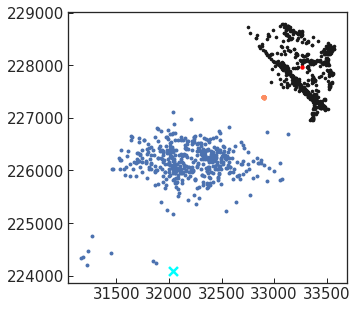

[405]
[[ 34191.63016482 229010.89094049 123180.40504114]]
405


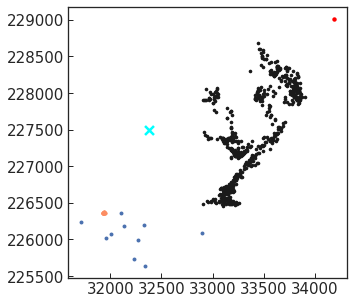

[406]
[[ 32716.11053594 227233.78681046 121869.03854161]]
406


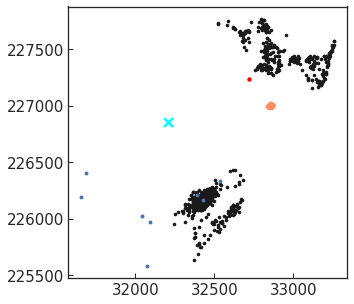

[407]
[[ 32350.55382856 225487.95540106 121433.48661313]]
407


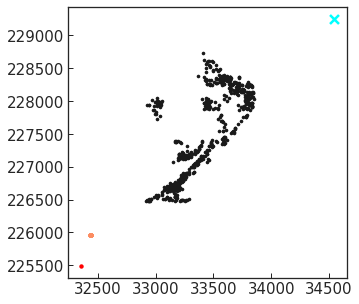

[408]
[[ 32052.9153859  224910.19023203 122344.45267444]]
408


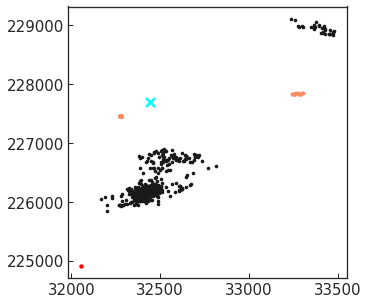

[409]
[[ 32116.30303536 227196.66771651 122069.44093272]]
409


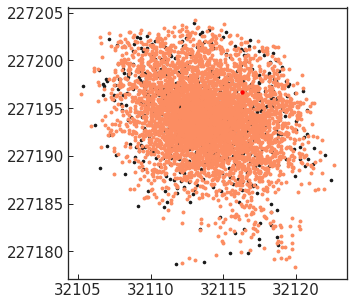

In [122]:
p = 4
for sidx in range(400,410):
    sstart = sOffset[sidx]
    send   = (sOffset[sidx] + sLength[sidx].astype(np.int64))
    # m1 = sMass[sidx][p]
    # m2 = sum(pig2['%d/Mass'%p][sstart[p]:send[p]])
    # assert np.allclose(m1,m2),"%.1e,%.1e"%(m1,m2)
    dpos = pig2['1/Position'][sstart[1]:send[1]] 
    gpos = pig2['0/Position'][sstart[0]:send[0]] 
    spos = pig2['4/Position'][sstart[4]:send[4]] 
    bpos = pig2['5/Position'][sstart[5]:send[5]] 
    print(pig2['5/SubgroupID'][sstart[5]:send[5]])
    
    print(bpos)
    # target = pig2['5/Position'][bidx_trouble[i]] 
    center = pig2['SubGroups/SubhaloPos'][sidx] 

    print(sidx)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    # ax[i].scatter(pos[:,0],pos[:,1],s=1,color='grey')
    ax.scatter(center[0],center[1],color='cyan',marker='x',s=80)
    ax.scatter(dpos[:,0],dpos[:,1],s=2,color='k')
    ax.scatter(gpos[:,0],gpos[:,1],s=3,color='b')
    ax.scatter(spos[:,0],spos[:,1],s=3,color=cmap(1))
    ax.scatter(bpos[:,0],bpos[:,1],s=5,color='red')
    # ax.scatter(target[0],target[1],s=50,color='green')

    # ax.set_title('Group %d Subgroup %d'%(gidx,isub),fontsize=12)
    # ax.set(xticklabels=[],yticklabels=[])
    plt.show()

### chunk data

In [65]:
def subhalo_offset(tabfile):
    SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
    GroupLenType = h5py.File(tabfile,'r')['Group']['GroupLenType'][:]
    GroupNsubs = h5py.File(tabfile,'r')['Group']['GroupNsubs'][:]
    GroupFirst = h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]
    
    SubhaloOffsetType = np.zeros_like(SubhaloLenType,dtype=int)
    GroupOff = np.zeros(6,dtype=int)
    SubOff = np.zeros(6,dtype=int)
    for ig,lgroup in enumerate(GroupLenType):
        SubOff[:] = GroupOff[:]
        nsub = GroupNsubs[ig]
        firstsub = GroupFirst[ig]
        if firstsub == -1:
            GroupOff += lgroup
            continue
        for isub in range(firstsub,firstsub + nsub):
            SubhaloOffsetType[isub] = SubOff
            SubOff += SubhaloLenType[isub]
        GroupOff += lgroup
    return SubhaloOffsetType

In [22]:
SubhaloLenType = h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:]
SubhaloOffsetType = np.zeros_like(SubhaloLenType)
SubhaloOffsetType[1:] = np.cumsum(SubhaloLenType[:-1],axis=0)

In [94]:
h5py.File(tabfile,'r')['Group']['GroupFirstSub'][:]

array([   0, 4078,   -1,   -1,   -1,   -1,   -1, 4082,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1],
      dtype=int32)

In [92]:
grpfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk1.2/output/snap-groupordered_348.hdf5'
tabfile = '/hildafs/datasets/Asterix/subfind/subfind_348/chunk1.2/output/fof_subhalo_tab_348.hdf5'
center = h5py.File(tabfile,'r')['Subhalo/SubhaloPos'][:]
pos1 = h5py.File(grpfile,'r')['PartType1/Coordinates'][:]
pos4 = h5py.File(grpfile,'r')['PartType4/Coordinates'][:]
pos5 = h5py.File(grpfile,'r')['PartType5/Coordinates'][:]
# offset = h5py.File(tabfile,'r')['Subhalo/SubhaloOffsetType'][:]
length = h5py.File(tabfile,'r')['Subhalo/SubhaloLenType'][:]
minids = h5py.File(tabfile,'r')['Subhalo/SubhaloIDMostbound'][:]
offset = subhalo_offset(tabfile)

In [70]:
len(h5py.File(tabfile,'r')['Subhalo']['SubhaloLenType'][:])

8487

In [83]:
ids = {}
ids[0] = h5py.File(grpfile,'r')['PartType0/ParticleIDs'][:]
ids[1] = h5py.File(grpfile,'r')['PartType1/ParticleIDs'][:]
ids[4] = h5py.File(grpfile,'r')['PartType4/ParticleIDs'][:]
ids[5] = h5py.File(grpfile,'r')['PartType5/ParticleIDs'][:]

In [90]:
for i in range(230,235):
    beg,end = offset[i], offset[i] + length[i]
    print(length[i])
    print(beg,end)
    minid = minids[i]
    for p in [0,1,4,5]:
        if minid in ids[p]:
            idx, = np.where(ids[p]==minid)[0]
            print(minid,p,idx)

[   0 1561    0    0 2132    1]
[13255031 19946466        0        0 22000193     1703] [13255031 19948027        0        0 22002325     1704]
144115378195255160 4 22000193
[   0 1251    0    0 2429    2]
[13255031 19948027        0        0 22002325     1704] [13255031 19949278        0        0 22004754     1706]
72057785578934148 4 22002325
[   0 2412    0    0 1190    1]
[13255031 19949278        0        0 22004754     1706] [13255031 19951690        0        0 22005944     1707]
216172975892707130 4 22004754
[   0 2216    0    0 1370    1]
[13255031 19951690        0        0 22005944     1707] [13255031 19953906        0        0 22007314     1708]
72057787392988207 4 22037254
[   0  812    0    0 2752    1]
[13255031 19953906        0        0 22007314     1708] [13255031 19954718        0        0 22010066     1709]
144115375139163589 4 22065976


105


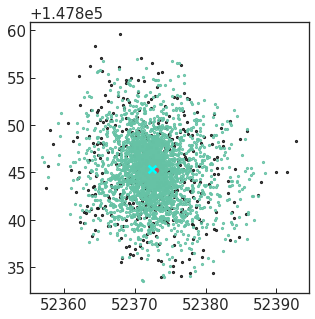

106


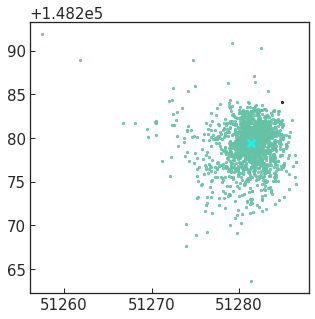

107


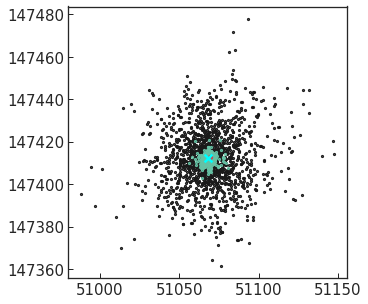

108


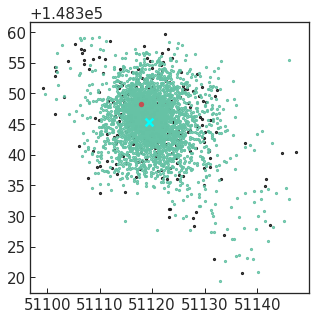

109


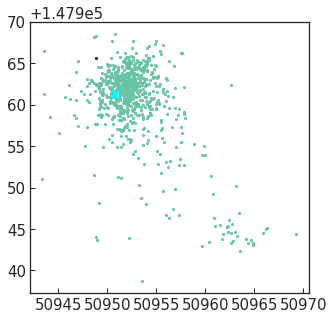

110


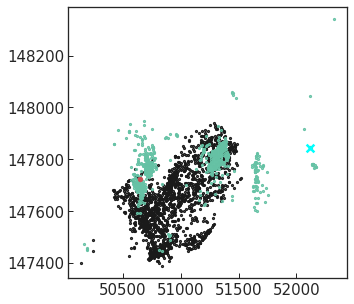

111


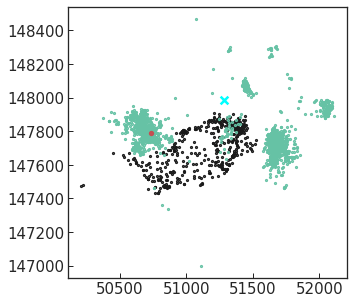

In [100]:

# plt.scatter(pos4g[:,0],pos4g[:,1],s=1,color='grey')
for i in range(105,112):
    print(i)
    fig = plt.figure(figsize=(5,5))
    
    beg,end = offset[i], offset[i] + length[i]
    
    # plt.scatter(pos4[:,0],pos4[:,1],color='grey',s=0.1)
    
    plt.scatter(pos1[beg[1]:end[1]][:,0],pos1[beg[1]:end[1]][:,1],s=1,color='k')
    plt.scatter(pos4[beg[4]:end[4]][:,0],pos4[beg[4]:end[4]][:,1],s=1)
    plt.scatter(pos5[beg[5]:end[5]][:,0],pos5[beg[5]:end[5]][:,1],s=10,color='r')
    plt.scatter(center[i][0],center[i][1],s=60,color='cyan',marker='x')

    # print(length[i][4])

    plt.show()

2031


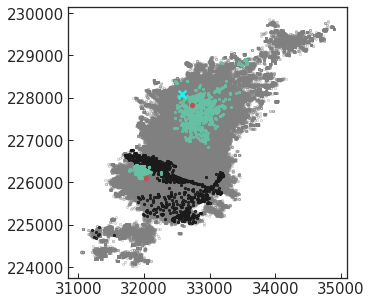

334


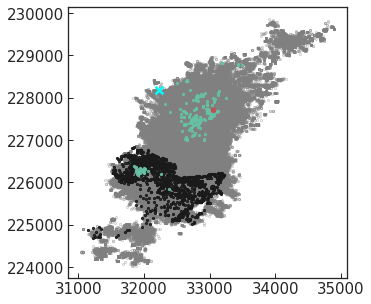

In [29]:

# plt.scatter(pos4g[:,0],pos4g[:,1],s=1,color='grey')
for i in range(250,252):
    fig = plt.figure(figsize=(5,5))
    
    beg,end = offset[i], offset[i] + length[i]
    
    plt.scatter(pos4[:,0],pos4[:,1],color='grey',s=0.1)
    
    plt.scatter(pos1[beg[1]:end[1]][:,0],pos1[beg[1]:end[1]][:,1],s=1,color='k')
    plt.scatter(pos4[beg[4]:end[4]][:,0],pos4[beg[4]:end[4]][:,1],s=1)
    plt.scatter(pos5[beg[5]:end[5]][:,0],pos5[beg[5]:end[5]][:,1],s=10,color='r')
    plt.scatter(center[i][0],center[i][1],s=60,color='cyan',marker='x')

    print(length[i][4])

    plt.show()